In [1]:
using DiffEqJump, StochasticDiffEq, DiffEqCallbacks
using StatsBase, Parameters, Plots, Distributions

In [2]:
# invariant parameters 
function drift(du,u,p,t) # constant drift
      du .= p.μ
end
function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end

# main params bundle
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 30, # num particles (==== 30 instead of 10 ====)
    β = 0.2, # rate parameter
    t = 0.:0.01:30., # time steps to save (==== 30 instead of 10 ====)
    moments = Array{Array{Float64, 1}, 1}(), # container for moments
    α = 2.0, # shape parameter for the initial condition distribution
    iv_dist = Exponential(1/α), # updates based on supplied α
    trajectories = 2, # number of members for ensemble methods 
    jump_algorithm = SRIW1(), # jump diffeq algorithm
    drift = drift, 
    volatility = volatility,
    ρ_max = 2.0,
    g_print_lower = -30, # print verbose statistics if g is lower than this
    g_print_upper = 15) # print verbose statistics if g is higher than this

#3 (generic function with 2 methods)

In [3]:
# generator functions
function generate_jump_prob(p, rate_index, affect_index!)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jumps = [VariableRateJump((u, p, t) -> rate_index(u, p, t, i), (integrator) -> affect_index!(integrator, i)) for i in 1:p.N];
    jump_prob = JumpProblem(sde_prob, DirectFW(), JumpSet((jumps),(),nothing,nothing))
    return jump_prob
end

function generate_ensemble_prob(jump_prob)
    function write_moments(sol, i)
        newsol = DiffEqBase.build_solution(sol.prob, sol.alg, sol.prob.p.t, sol.prob.p.moments)
        return newsol, false
    end
    function calculate_moments(u, t, integrator) 
        # g calculated w.r.t. mean
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), median(u), maximum(u), g]
        # verbose g logic
        if g < integrator.p.g_print_lower || g > integrator.p.g_print_upper 
            @show moments # current period moments
            if length(integrator.p.moments) > 0 
                @show integrator.p.moments[end] # last period moments (haven't pushed yet)
            end
        end
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(jump_prob, output_func = write_moments)    
    return ensemble_prob, cb
end

generate_ensemble_prob (generic function with 1 method)

### Default (Broken) Output

moments = [-3.44247, -0.0226948, 0.17181, 1.92048, 24.7773]
(integrator.p).moments[end] = [-62.0952, -0.270468, 0.557583, 12.7204, -2.69628]
moments = [-3.56383, 0.576257, 0.636404, 2.81914, 21.191]
(integrator.p).moments[end] = [-22.1397, 0.364347, 0.803683, 3.07847, -1.07797]
moments = [-5.98197, -0.395101, 0.00551805, 1.37372, 16.6813]
(integrator.p).moments[end] = [-16.2042, -0.561914, 0.0071319, 1.52461, -3.61022]
moments = [-48.9605, -0.367899, 0.219526, 8.09352, -30.8766]
(integrator.p).moments[end] = [-18.3017, -0.0591328, 0.0513583, 3.2388, -18.274]
moments = [-79.6194, -0.676664, 0.304411, 12.9482, -30.8766]
(integrator.p).moments[end] = [-48.9605, -0.367899, 0.219526, 8.09352, -30.8766]
moments = [-110.278, -0.98543, 0.412799, 17.803, -30.8766]
(integrator.p).moments[end] = [-79.6194, -0.676664, 0.304411, 12.9482, -30.8766]
moments = [-140.937, -1.2942, 0.569219, 22.6577, -30.8766]
(integrator.p).moments[end] = [-110.278, -0.98543, 0.412799, 17.803, -30.8766]
moments = [-171

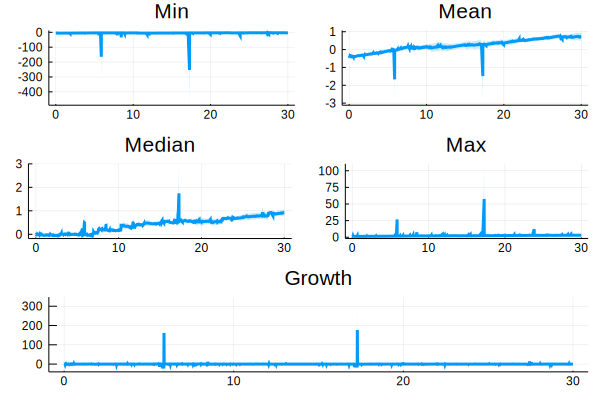

In [4]:
function rate_index(u, p, t, index)
   u_max = maximum(u)
   u_min = minimum(u)
   return p.ρ_max* ((u[index] - u_max)^2 / (u_max - u_min))
end
affect_index!(integrator, index) = (integrator.u[index] = max(integrator.u[index], integrator.u[rand(1:integrator.p.N)]))

p = params()
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Median")
p4 = plot(summ, idxs = [4], title = "Max")
p5 = plot(summ, idxs = [5], title = "Growth")
l = @layout [a b; c d ; d]

plot(p1, p2, p3, p4, p5, layout = l)

### New Algorithm

moments = [-21.4787, -0.258199, 0.0404669, 2.07879, -33.4442]
(integrator.p).moments[end] = [-4.02622, 0.0762425, 0.0682933, 1.91131, 0.155704]
moments = [-4.37492, 0.00958428, 0.0565904, 1.93707, 26.7783]
(integrator.p).moments[end] = [-21.4787, -0.258199, 0.0404669, 2.07879, -33.4442]
moments = [-746.686, -10.5575, 0.419458, 74.6255, -1108.2]
(integrator.p).moments[end] = [-3.3079, 0.524553, 0.676497, 2.70559, 0.166543]
moments = [-5.67148, 0.441672, 0.656135, 2.70202, 1099.92]
(integrator.p).moments[end] = [-746.686, -10.5575, 0.419458, 74.6255, -1108.2]
moments = [-5.58873, 0.470013, 0.64418, 2.64075, 52.2587]
(integrator.p).moments[end] = [-42.4872, -0.0525743, 0.0415612, 15.2269, -22.1166]
moments = [-80.7606, -0.0296356, 0.869043, 41.5871, -65.6856]
(integrator.p).moments[end] = [-5.10269, 0.62722, 0.591654, 2.78034, 0.0687095]
moments = [-5.10057, 0.602715, 0.858849, 2.75994, 63.2351]
(integrator.p).moments[end] = [-80.7606, -0.0296356, 0.869043, 41.5871, -65.6856]
moments = [-

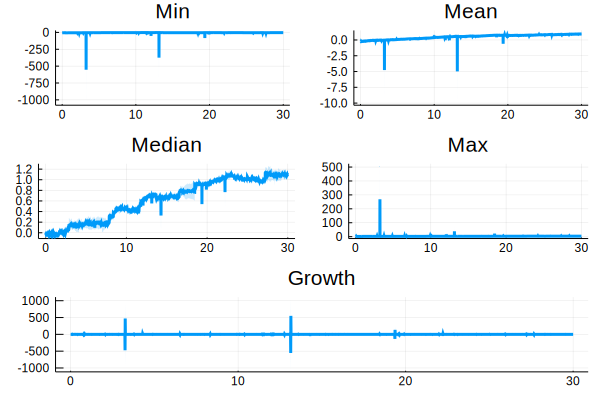

In [5]:
p = params(jump_algorithm = SOSRI())
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Median")
p4 = plot(summ, idxs = [4], title = "Max")
p5 = plot(summ, idxs = [5], title = "Growth")
l = @layout [a b; c d ; d]

plot(p1, p2, p3, p4, p5, layout = l)

### No Affect

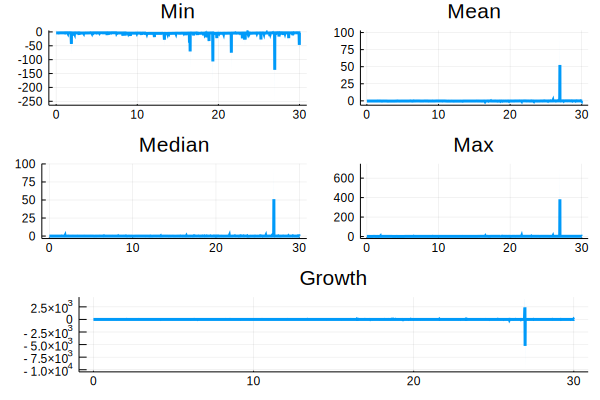

In [6]:
affect_index!(integrator, index) = nothing

p = params(g_print_lower = -Inf, g_print_upper = Inf)
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Median")
p4 = plot(summ, idxs = [4], title = "Max")
p5 = plot(summ, idxs = [5], title = "Growth")
l = @layout [a b; c d ; d]

plot(p1, p2, p3, p4, p5, layout = l)

### No Variable Rate

moments = [-4.18451, 1.44335, 1.72144, 3.93107, -552.677]
(integrator.p).moments[end] = [-286.197, 6.97012, 12.7467, 152.125, 552.163]


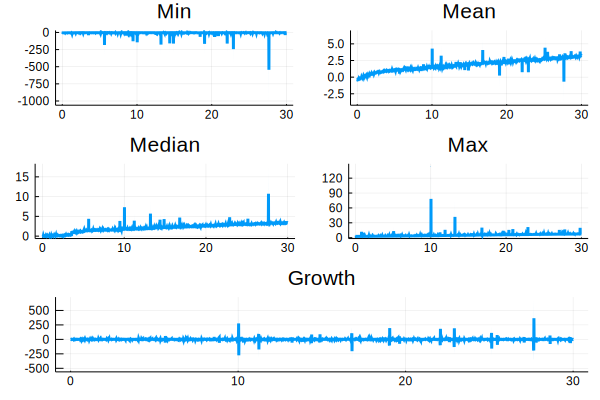

In [7]:
rate_index(u, p, t, i) = 2 # constant across indices, times, etc.
affect_index!(integrator, index) = (integrator.u[index] = max(integrator.u[index], integrator.u[rand(1:integrator.p.N)])) # original 

p = params(g_print_lower = -500, g_print_upper = 1000)
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Median")
p4 = plot(summ, idxs = [4], title = "Max")
p5 = plot(summ, idxs = [5], title = "Growth")
l = @layout [a b; c d ; d]

plot(p1, p2, p3, p4, p5, layout = l)

### Neither Affect nor Variable Rate

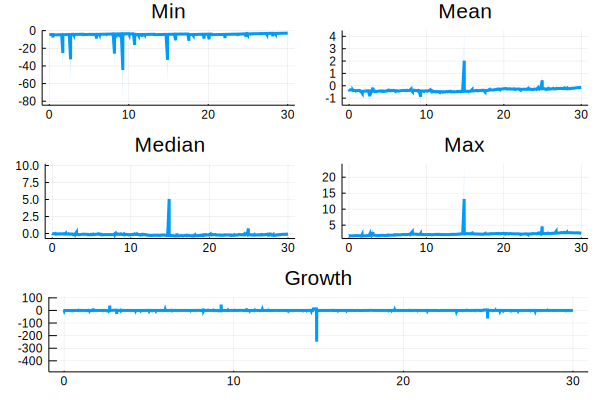

In [8]:
rate_index(u, p, t, i) = 0.2 # constant across indices, times, etc.
affect_index!(integrator, index) = nothing

p = params(g_print_lower = -Inf, g_print_upper = Inf)
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Median")
p4 = plot(summ, idxs = [4], title = "Max")
p5 = plot(summ, idxs = [5], title = "Growth")
l = @layout [a b; c d ; d]

plot(p1, p2, p3, p4, p5, layout = l)

### ConstantRateJump Sanity Check

In [9]:
# generator functions
function generate_jump_prob(p, rate_index, affect_index!)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jumps = [ConstantRateJump((u, p, t) -> rate_index(u, p, t, i), (integrator) -> affect_index!(integrator, i)) for i in 1:p.N];
    jump_prob = JumpProblem(sde_prob, DirectFW(), JumpSet((), jumps, nothing, nothing))
    return jump_prob
end

function generate_ensemble_prob(jump_prob)
    function write_moments(sol, i)
        newsol = DiffEqBase.build_solution(sol.prob, sol.alg, sol.prob.p.t, sol.prob.p.moments)
        return newsol, false
    end
    function calculate_moments(u, t, integrator) 
        # g calculated w.r.t. mean
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), median(u), maximum(u), g]
        # verbose g logic
        if g < integrator.p.g_print_lower || g > integrator.p.g_print_upper 
            @show moments # current period moments
            if length(integrator.p.moments) > 0 
                @show integrator.p.moments[end] # last period moments (haven't pushed yet)
            end
        end
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(jump_prob, output_func = write_moments)    
    return ensemble_prob, cb
end

generate_ensemble_prob (generic function with 1 method)

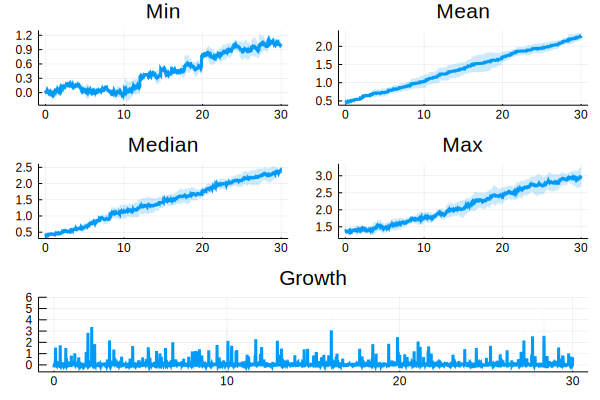

In [10]:
rate_index(u, p, t, i) = 0.2 # constant across indices, times, etc.
function affect!(integrator, i)
  n = rand(1:integrator.p.N)
  n2 = rand(1:integrator.p.N)
  integrator.u[n] = max(integrator.u[n], integrator.u[n2])
end

p = params(g_print_lower = -Inf, g_print_upper = Inf)
jump_prob = generate_jump_prob(p, rate_index, affect!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Median")
p4 = plot(summ, idxs = [4], title = "Max")
p5 = plot(summ, idxs = [5], title = "Growth")
l = @layout [a b; c d ; d]

plot(p1, p2, p3, p4, p5, layout = l)